In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

CSV_FILE = "books.csv"

In [72]:
df = pd.read_csv(CSV_FILE)
display(df.head())
df.dtypes

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


bookID                 int64
title                 object
authors               object
average_rating        object
isbn                  object
isbn13                object
language_code         object
num_pages             object
ratings_count          int64
text_reviews_count     int64
publication_date      object
publisher             object
dtype: object

In [73]:
df["publication_date"] = pd.to_datetime(df["publication_date"])
df = df[df['num_pages'].str.isnumeric()]
df["num_pages"] = df["num_pages"].astype(int)
df["average_rating"] = df["average_rating"].astype(float)

In [74]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic


In [75]:
df.describe()

,bookID,average_rating,num_pages,ratings_count,text_reviews_count,publication_date
count,11121.000000,11121.000000,11121.000000,1.112100e+04,11121.000000,11121
mean,21307.774301,3.934058,336.343944,1.794512e+04,542.118874,2000-08-29 03:05:33.099541504
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000,1900-01-01 00:00:00
25%,10270.000000,3.770000,192.000000,1.040000e+02,9.000000,1998-07-17 00:00:00
50%,20264.000000,3.960000,299.000000,7.450000e+02,47.000000,2003-03-01 00:00:00
75%,32104.000000,4.140000,416.000000,4.996000e+03,238.000000,2005-10-01 00:00:00
max,45641.000000,5.000000,6576.000000,4.597666e+06,94265.000000,2020-03-31 00:00:00
std,13093.542472,0.350513,241.129968,1.125091e+05,2576.845134,NaN


In [76]:
from datetime import datetime
df["days_since_publication"] = (datetime.now() - df["publication_date"]).dt.days

In [77]:
df["authors"] = df["authors"].str.split("/")


In [78]:
df["num_authors"] = df["authors"].apply(len)
display(df.explode("authors").groupby("authors")["average_rating"].mean().sort_values(ascending=False))


authors
R. McL. Wilson                          5.0
William C. Dowling                      5.0
Chris    Green                          5.0
David Sylvester                         5.0
Middlesex Borough Heritage Committee    5.0
                                       ... 
Michael John Petry                      0.0
Rem Koolhaas                            0.0
Anthony Thwaite                         0.0
Robert A. Weiss                         0.0
J. Martin Evans                         0.0
Name: average_rating, Length: 9230, dtype: float64

In [79]:
df.explode("authors").groupby("authors").agg({"average_rating": "mean", "ratings_count": "sum"}).sort_values(by=["average_rating", "ratings_count"], ascending=[False, False])

,average_rating,ratings_count
authors,,
John Diamond,5.0,5
Elena N. Mahlow,5.0,4
Alisa Klayman-Grodsky,5.0,2
Dennis Adler,5.0,2
Eric Weiner,5.0,2
...,...,...
Rick Osborne,0.0,0
Robert A. Weiss,0.0,0
Strawberry Saroyan,0.0,0


In [80]:
author_stats = df.explode("authors").groupby("authors").agg(
    average_rating=("average_rating", "mean"),
    total_ratings=("ratings_count", "sum"),
)
author_stats["score"] = author_stats["average_rating"] * author_stats["total_ratings"]
author_stats.sort_values(by="score", ascending=False)

,average_rating,total_ratings,score
authors,,,
J.K. Rowling,4.500000,9265287,4.169379e+07
Mary GrandPré,4.548333,8923980,4.058924e+07
J.R.R. Tolkien,4.218000,5622283,2.371479e+07
Stephen King,4.008687,4288299,1.719045e+07
Stephenie Meyer,3.590000,4597666,1.650562e+07
...,...,...,...
Robert L. Geneve,3.830000,0,0.000000e+00
Bruce Alvin King,2.000000,0,0.000000e+00
Ian Hamilton,0.000000,0,0.000000e+00


In [81]:
author_stats = author_stats[author_stats["total_ratings"] > 0]
author_stats.sort_values(by="score", ascending=False)

,average_rating,total_ratings,score
authors,,,
J.K. Rowling,4.500000,9265287,4.169379e+07
Mary GrandPré,4.548333,8923980,4.058924e+07
J.R.R. Tolkien,4.218000,5622283,2.371479e+07
Stephen King,4.008687,4288299,1.719045e+07
Stephenie Meyer,3.590000,4597666,1.650562e+07
...,...,...,...
R.R. Palmer,2.000000,1,2.000000e+00
Mymi Doinet,2.000000,1,2.000000e+00
Benjamin Chaud,2.000000,1,2.000000e+00


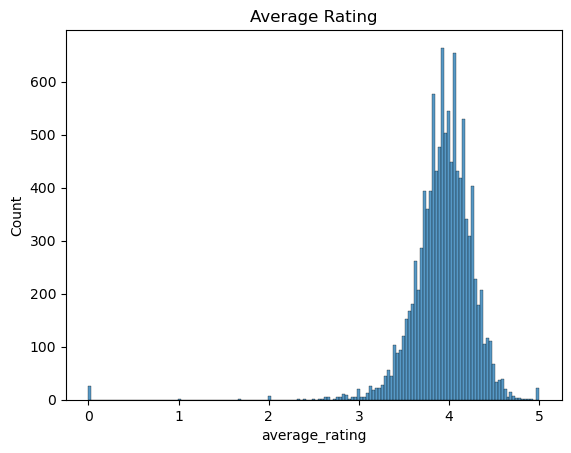

In [82]:
fig, ax = plt.subplots()
sns.histplot(data=df, x="average_rating", ax=ax)
ax.set_title("Average Rating")
plt.savefig("average_rating.png", dpi=300)

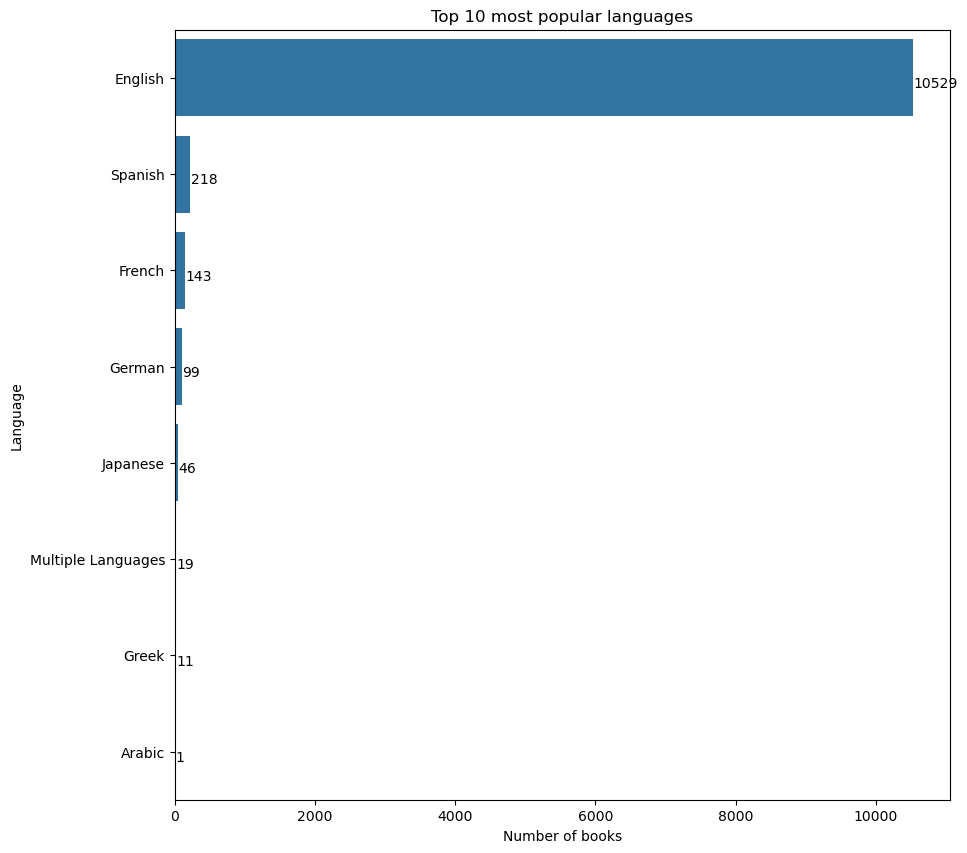

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))
lang_map = {
    'eng': 'English',
    'en-US': 'English',
    'en-GB': 'English',
    'fre': 'French',
    'spa': 'Spanish',
    'ger': 'German',
    'jpn': 'Japanese',
    'mul': 'Multiple Languages',
    'grc': 'Greek',
    'ara': 'Arabic',
}
df["language_code"] = df["language_code"].map(lang_map)

sns.countplot(data=df, y="language_code", ax=ax, orient="h", order=df["language_code"].value_counts().index)
ax.set_title("Top 10 most popular languages")
ax.set_xlabel("Number of books")
ax.set_ylabel("Language")
for p in ax.patches:
    ax.annotate(f"{int(p.get_width())}", (p.get_width() + 10, p.get_y() + 0.5))